<a href="https://colab.research.google.com/github/Joao-vitor1/fine-tuning-colonial-pt/blob/main/fine_tuning_gemma2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# codigo final

## baixando bibliotecas

In [ ]:
!pip install -U "transformers" "datasets" "peft" "accelerate" "bitsandbytes" "trl"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.6/336.6 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.9/313.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import torch
from datasets import Dataset, load_dataset
from random import randrange
from peft import LoraConfig, get_peft_model, AutoPeftModelForCausalLM
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, TrainingArguments, GemmaTokenizer
from transformers import BatchEncoding, AutoConfig
from trl import SFTTrainer, SFTConfig
from huggingface_hub import notebook_login
import torch
import os
from torch import autocast
import gc

os.environ['WANDB_DISABLED'] = "true"

In [ ]:
notebook_login()

# Fine Tuning

In [ ]:
#Fine tunning
model_id = "google/gemma-2-2b-it"
#https://huggingface.co/google/gemma-27b-it

# Get the type
compute_dtype = getattr(torch, "float16")

# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype
)

# Load the pretrained model.................................................................
model_2b = AutoModelForCausalLM.from_pretrained(model_id,
                                                quantization_config=bnb_config,
                                                device_map="auto",
                                                )

# Load the tokenizer..............................................................................
tokenizer_2b = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
tokenizer_2b.pad_token = tokenizer_2b.eos_token
tokenizer_2b.padding_side = "right"

#model's token limit.........................................................................
config = AutoConfig.from_pretrained(model_id)
token_limit =config.max_position_embeddings
token_limit

model-00001-of-00002.safetensors:   4%|4         | 210M/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

8192

## importando dataset

In [ ]:
df_ft = pd.read_csv('/content/dataset_output (2).csv')
df_ft['concat'] = df_ft['input'] + ' ' + df_ft['output']

DS = Dataset.from_pandas(df_ft[['concat']])
splited_DS= DS.train_test_split(test_size=0.2, seed = 42)


In [ ]:
train = splited_DS['train']
train

Dataset({
    features: ['concat'],
    num_rows: 36
})

In [ ]:
test = splited_DS['test']
test

Dataset({
    features: ['concat'],
    num_rows: 10
})

## treinando

In [ ]:
lora_config = LoraConfig(
                          r = 2, # (ALTERADO) mudei r =8 para r = 2 para ver se consome menos memória
                          target_modules =  ["q_proj", "o_proj", "k_proj", "v_proj", #  queries, keys, values e output
                                             "gate_proj", "up_proj", "down_proj"],  # relacionado ao  feed-forward (entender melhor)
                          task_type = 'CAUSAL_LM', #tipo de tarefa: predizer a próxima palavra com base nas anteriores
                          lora_dropout=0.01,
                          bias="none",
)

In [ ]:
# Copyright 2025 The HuggingFace Team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from dataclasses import dataclass, field
from typing import Any, Optional
from transformers import TrainingArguments


@dataclass
class SFTConfig(TrainingArguments):
    dataset_text_field: str = field(
        default="concat",
        metadata={
            "help": "Name of the text field of the dataset. If provided, the trainer will automatically create a "
            "`ConstantLengthDataset` based on `dataset_text_field`."
        },
    )
    packing: bool = field(
        default=False,
        metadata={"help": "Controls whether the `ConstantLengthDataset` packs the sequences of the dataset."},
    )
    learning_rate: float = field(
        default=2.0e-4,
        metadata={
            "help": "Initial learning rate for `AdamW` optimizer. The default value replaces that of "
            "`TrainingArguments`."
        },
    )
    max_seq_length: Optional[int] = field(
        default=None,
        metadata={
            "help": "Maximum sequence length for the `ConstantLengthDataset` and for automatically creating the "
            "dataset. If `None`, it uses the smaller value between `tokenizer.model_max_length` and `1024`."
        },
    )
    dataset_num_proc: Optional[int] = field(
        default=None,
        metadata={"help": "Number of processes to use for processing the dataset. Only used when `packing=False`."},
    )
    dataset_batch_size: int = field(
        default=1,
        metadata={
            "help": "Number of examples to tokenize per batch. If `dataset_batch_size <= 0` or `dataset_batch_size is "
            "None`, tokenizes the full dataset as a single batch."
        },
    )
    model_init_kwargs: Optional[dict[str, Any]] = field(
        default=None,
        metadata={
            "help": "Keyword arguments to pass to `AutoModelForCausalLM.from_pretrained` when instantiating the model "
            "from a string."
        },
    )
    dataset_kwargs: Optional[dict[str, Any]] = field(
        default=None,
        metadata={
            "help": "Dictionary of optional keyword arguments to pass when creating packed or non-packed datasets."
        },
    )
    eval_packing: Optional[bool] = field(
        default=None,
        metadata={"help": "Whether to pack the eval dataset. If `None`, uses the same value as `packing`."},
    )
    num_of_sequences: int = field(
        default=1024,
        metadata={"help": "Number of sequences to use for the `ConstantLengthDataset`."},
    )
    chars_per_token: float = field(
        default=3.6, metadata={"help": "Number of characters per token to use for the `ConstantLengthDataset`."}
    )
    use_liger: bool = field(
        default=False,
        metadata={"help": "Monkey patch the model with Liger kernels to increase throughput and reduce memory usage."},
    )


In [ ]:

from transformers import DataCollatorForLanguageModeling
trainer = SFTTrainer(
    model=model_2b,
    train_dataset=train,
    eval_dataset=test,
    args=SFTConfig( #(ALTERADO)  mudei de TrainingArguments para SFTConfig
        dataset_text_field="concat",
        num_train_epochs=10,
        # max_steps=36*10,
        per_device_train_batch_size=1,
        gradient_accumulation_steps=2,  # Accumulate gradients over 2 steps (ADICIONADO)
        # evaluation_strategy="steps",
        logging_strategy="steps",
        save_strategy="steps",
        logging_steps=1,
        learning_rate=2e-4,
        fp16=True,
        output_dir='gemma-tunned',
        gradient_checkpointing=True, #o que faz?
    ),
    peft_config=lora_config,
    # data_collator= DataCollatorForLanguageModeling(tokenizer_2b, #faz pré-processamento dos dados
                                                              #  mlm=False),  #mlm é para treinamento de mascaramento, tipo bert
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Map:   0%|          | 0/36 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/trl/trainer/sft_trainer.py:300: UserWarning: You passed a processing_class with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `processing_class.padding_side = 'right'` to your code.
  warnings.warn(


In [ ]:
model_2b.gradient_checkpointing_enable()
display(trainer.train())

Step,Training Loss
1,2.674700
2,3.203300
3,4.846700
4,3.123900
5,2.758400
6,2.780200
7,3.069900
8,2.688600
9,1.954300
10,4.117800


TrainOutput(global_step=180, training_loss=1.8241203097833527, metrics={'train_runtime': 574.0724, 'train_samples_per_second': 0.627, 'train_steps_per_second': 0.314, 'total_flos': 3072901700275200.0, 'train_loss': 1.8241203097833527, 'epoch': 10.0})

In [ ]:
df_loss = pd.DataFrame(trainer.state.log_history)
df_loss[['loss', 'epoch','step']].to_csv('loss_gemma_2b.csv')
df_loss['epoch'].head(20)

,epoch
0,0.055556
1,0.111111
2,0.166667
3,0.222222
4,0.277778
5,0.333333
6,0.388889
7,0.444444
8,0.500000
9,0.555556


In [ ]:
# Empty VRAM
del model_2b
del trainer
import gc
gc.collect() #forçar o delet no colletor de lixo da GPU

torch.cuda.empty_cache() #libera memória da GPU

gc.collect() #nao entendi esta parte

35803

In [ ]:
%%time
from peft import AutoPeftModelForCausalLM

new_model = AutoPeftModelForCausalLM.from_pretrained(
    'gemma-tunned/checkpoint-180', # Change for the checkpoint you want to load
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map="auto",
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 8.7 s, sys: 3.86 s, total: 12.6 s
Wall time: 14.9 s


In [ ]:
# Merge LoRA and base model
merged_model = new_model.merge_and_unload()

In [ ]:
# Save the merged model
merged_model.save_pretrained("gemma-7b-tuned-merged", safe_serialization=True)

In [ ]:
tokenizer_2b.save_pretrained("gemma-7b-tuned-merged")

('gemma-7b-tuned-merged/tokenizer_config.json',
 'gemma-7b-tuned-merged/special_tokens_map.json',
 'gemma-7b-tuned-merged/tokenizer.model',
 'gemma-7b-tuned-merged/added_tokens.json',
 'gemma-7b-tuned-merged/tokenizer.json')

## estatísticas

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
df_loss = pd.read_csv('/content/loss_gemma_2b.csv')

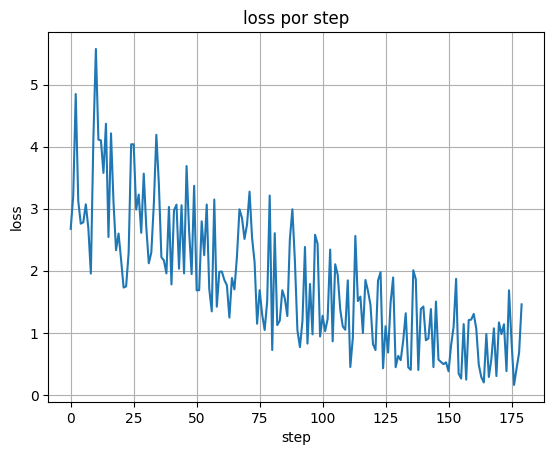

In [ ]:
plt.plot(df_loss['loss'])
plt.title('loss por step')
plt.xlabel('step')
plt.ylabel('loss')
plt.grid(True)
plt.show()

In [ ]:
# 1 epoca = 18 steps
epoch_loss = []
soma_loss = 0.0
count = 0
for loss in df_loss['loss']:
  count +=1
  soma_loss += loss
  if count % 18 == 0:
    soma_loss = soma_loss / 18
    epoch_loss.append(soma_loss)
    soma_loss = 0.0

df_epoch_loss = pd.DataFrame({'epoch_loss': epoch_loss})
df_epoch_loss

,epoch_loss
0,3.488889
1,2.839589
2,2.460478
3,2.205928
4,1.798533
5,1.503717
6,1.327294
7,1.054717
8,0.832894
9,0.729172


In [ ]:
import numpy as np

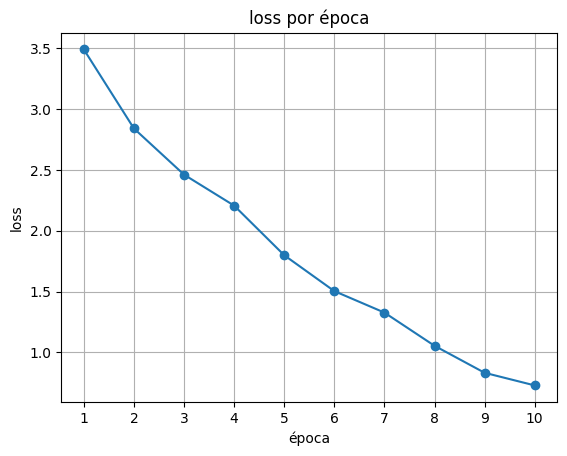

In [ ]:
plt.plot(np.arange(1, 11), df_epoch_loss['epoch_loss'], marker='o', linestyle='-')
plt.xticks(np.arange(1, 11, 1))
plt.title('loss por época')
plt.xlabel('época')
plt.ylabel('loss')
plt.grid(True)
plt.show()

## Salvando modelo

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
# push merged model to the hub
%%time
hf_model_repo = "JoaoVitorIA/fine-tunning-gemma2"
merged_model.push_to_hub(hf_model_repo)
tokenizer_2b.push_to_hub(hf_model_repo)

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 1.11 s, sys: 190 ms, total: 1.3 s
Wall time: 3.83 s


CommitInfo(commit_url='https://huggingface.co/JoaoVitorIA/fine-tunning-gemma2/commit/c4cb73741c73a3e8ef53f51f5f2bd2fc800984b4', commit_message='Upload tokenizer', commit_description='', oid='c4cb73741c73a3e8ef53f51f5f2bd2fc800984b4', pr_url=None, repo_url=RepoUrl('https://huggingface.co/JoaoVitorIA/fine-tunning-gemma2', endpoint='https://huggingface.co', repo_type='model', repo_id='JoaoVitorIA/fine-tunning-gemma2'), pr_revision=None, pr_num=None)

# Inferência (falta finalizar)

In [ ]:
import pandas as pd
import torch
from datasets import Dataset, load_dataset
from random import randrange
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from huggingface_hub import notebook_login
import torch
import os

os.environ['WANDB_DISABLED'] = "true"

In [ ]:
#Fine tunning
model_id = "google/gemma-2-2b-it"
#https://huggingface.co/google/gemma-27b-it

# Get the type
compute_dtype = getattr(torch, "float16")

# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype
)

# Load the pretrained model.................................................................
model_2b = AutoModelForCausalLM.from_pretrained(model_id,
                                                quantization_config=bnb_config,
                                                device_map="auto",
                                                )

# Load the tokenizer..............................................................................
tokenizer_2b = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
tokenizer_2b.pad_token = tokenizer_2b.eos_token
tokenizer_2b.padding_side = "right"

config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

trained_model = "JoaoVitorIA/fine-tunning-gemma2"

# Get the tokenizer
tokenizer_trained = AutoTokenizer.from_pretrained(trained_model)

# Load the model
model_trained = AutoModelForCausalLM.from_pretrained(trained_model,
                                             quantization_config=bnb_config,
                                             device_map="auto")


tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/522 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/880 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

In [ ]:
df_ft = pd.read_csv('/content/dataset_output (2).csv')
df_ft['concat'] = df_ft['input'] + ' ' + df_ft['output']

DS = Dataset.from_pandas(df_ft)
splited_DS= DS.train_test_split(test_size=0.2, seed = 42)


In [ ]:
train_df = splited_DS['train']
print(train_df)
test_df = splited_DS['test']
print(test_df)

Dataset({
    features: ['Unnamed: 0', 'input', 'output', 'concat'],
    num_rows: 36
})
Dataset({
    features: ['Unnamed: 0', 'input', 'output', 'concat'],
    num_rows: 10
})


In [ ]:
print(test_df['input'][0])

<bos><start_of_turn>user traduza o texto abaixo escrito em português antigo para um português mais contemporâneo. Me dê apenas a tradução do texto, sem recomendações ou notas das mudanças feitas. Me retorne a resposta apenas em português.

 O texto para ser traduzido é este abaixo:
Que muyto bem me fez Nostro Senhor
aquel dia en que m' El foy monstrar
hÛa dona que fez melhor falar
de quantas fez, e parecer melhor.
E o dia em que mh-a fez veer,
El quis assi que foss' em seu poder,
u me podia nunca mays bem dar
nom ja em al, d' esto som sabedor
se m' algum tempo quisera leixar
ela servir, e non-na ir matar;
mays, poys la matou, serei sofredor
sempre de coyta enquant' eu viver,
ca sol u cuydo no seu parecer
ey morte mays d' outra rem desejar.
E poys eu nunca d' outra rem sabor
poss' atender pera me conortar,
muy bem posso com verdade jurar,
polos que dizem que an mal d' amor,
que com verdade nom poden dizer
porque cuydand' i tomam gram prazer,
o que a mim nunca pode chegar.
Nem esperança 

In [ ]:
print(test_df['output'][0])


Nosso Senhor me fez muito bem naquele dia em que me mostrou uma dama que fez melhor falar e parecer melhor do que todas as outras. E no dia em que me fez vê-la, Ele quis que estivesse ao Seu poder, para que nunca mais pudesse me dar tão bem, pois já sei que, se em algum tempo quisesse deixá-la servir e não a matar, mas, pois a matou, serei sofredor sempre de cota enquanto eu viver, porque só o Seu parecer e a morte mais do que outra coisa desejo. E pois eu nunca de outra coisa posso ter sabor, posso com verdade jurar, pelos que dizem que têm mal de amor, que com verdade não podem dizer porque, cuidando, tomam grande prazer, o que a mim nunca pode chegar. Nem esperança nunca posso ter de que com outros possa ter algum bem, pois meu bem nunca posso cobrar. 


<end_of_turn><eos>


In [ ]:
def resposta(model, tokenizer, df):
  texto_tokenizado = tokenizer(df['input'][0], return_tensors="pt", add_special_tokens = True).to("cuda:0")

  generated_ids = model.generate(**texto_tokenizado, max_new_tokens= 5000,
                                    do_sample=False, pad_token_id=tokenizer.eos_token_id).to("cuda:0")
  return tokenizer_2b.decode(generated_ids[0], skip_special_tokens=True)

In [ ]:
r_base_model = resposta(model_2b, tokenizer_2b, test_df)
print(r_base_model)

The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.


user traduza o texto abaixo escrito em português antigo para um português mais contemporâneo. Me dê apenas a tradução do texto, sem recomendações ou notas das mudanças feitas. Me retorne a resposta apenas em português.

 O texto para ser traduzido é este abaixo:
Que muyto bem me fez Nostro Senhor
aquel dia en que m' El foy monstrar
hÛa dona que fez melhor falar
de quantas fez, e parecer melhor.
E o dia em que mh-a fez veer,
El quis assi que foss' em seu poder,
u me podia nunca mays bem dar
nom ja em al, d' esto som sabedor
se m' algum tempo quisera leixar
ela servir, e non-na ir matar;
mays, poys la matou, serei sofredor
sempre de coyta enquant' eu viver,
ca sol u cuydo no seu parecer
ey morte mays d' outra rem desejar.
E poys eu nunca d' outra rem sabor
poss' atender pera me conortar,
muy bem posso com verdade jurar,
polos que dizem que an mal d' amor,
que com verdade nom poden dizer
porque cuydand' i tomam gram prazer,
o que a mim nunca pode chegar.
Nem esperança nunca poss' aver
com

In [ ]:
r_trained_model = resposta(model_trained, tokenizer_trained, test_df)
print(r_trained_model)

user traduza o texto abaixo escrito em português antigo para um português mais contemporâneo. Me dê apenas a tradução do texto, sem recomendações ou notas das mudanças feitas. Me retorne a resposta apenas em português.

 O texto para ser traduzido é este abaixo:
Que muyto bem me fez Nostro Senhor
aquel dia en que m' El foy monstrar
hÛa dona que fez melhor falar
de quantas fez, e parecer melhor.
E o dia em que mh-a fez veer,
El quis assi que foss' em seu poder,
u me podia nunca mays bem dar
nom ja em al, d' esto som sabedor
se m' algum tempo quisera leixar
ela servir, e non-na ir matar;
mays, poys la matou, serei sofredor
sempre de coyta enquant' eu viver,
ca sol u cuydo no seu parecer
ey morte mays d' outra rem desejar.
E poys eu nunca d' outra rem sabor
poss' atender pera me conortar,
muy bem posso com verdade jurar,
polos que dizem que an mal d' amor,
que com verdade nom poden dizer
porque cuydand' i tomam gram prazer,
o que a mim nunca pode chegar.
Nem esperança nunca poss' aver
com